In [1]:
#Importing all modules
import sys
import time
import os

import pandas as pd
import math
import numpy as np
import random

from loguru import logger
from pathlib import Path

from Naive.node import Node

In [2]:
time_series_data = pd.read_csv('Dataset/Sales_Transaction_Dataset_Weekly_Final.csv')
#time_series_data = pd.read_csv('Dataset/cgm.csv')
time_series_data


,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,P815,0,0,1,0,0,2,1,0,0,...,0,1,1,0,0,1,0,0,2,0
807,P816,0,1,0,0,1,2,2,6,0,...,3,3,4,2,4,5,5,5,6,5
808,P817,1,0,0,0,1,1,2,1,1,...,2,0,0,2,2,0,0,0,4,3
809,P818,0,0,0,1,0,0,0,0,1,...,0,0,0,1,1,0,0,0,2,0


In [3]:
columns = list(time_series_data.columns)
time_series_index = columns.pop(0)  # remove product code

time_series_dict = dict()

for index, row in time_series_data.iterrows():
    time_series_dict[row[time_series_index]] = list(row[columns])



In [4]:
def create_tree_phase(time_series_data, P_value, paa_value,max_level):
    
    good_leaf_nodes = list()
    bad_leaf_nodes = list()

    print("Create-tree phase: start node splitting")
    node = Node(level=1, group=time_series_data, paa_value=5)
    node.start_splitting(P_value, max_level, good_leaf_nodes, bad_leaf_nodes) # using naive method node splitting 
    
    return good_leaf_nodes, bad_leaf_nodes
    

In [5]:
def recycle_bad_leaves_phase(p_value,good_leaf_nodes, bad_leaf_nodes,paa_value):
    
    suppressed_nodes = list()
    bad_leaves_node_dict = dict()
        
    for node in bad_leaf_nodes:
        if node.level in bad_leaves_node_dict.keys():
            bad_leaves_node_dict[node.level].append(node)
        else:
            bad_leaves_node_dict[node.level] = [node]

    bad_leaf_nodes_size = sum([node.size for node in bad_leaf_nodes])
    
        
    if bad_leaf_nodes_size >= p_value:
        
        current_level = max(bad_leaves_node_dict.keys())
        
        while bad_leaf_nodes_size >= p_value:
            
            if current_level in bad_leaves_node_dict.keys():
                leave_merge_dict = dict()
                keys_remove_list = list()
                merge = False
                
                for current_level_node in bad_leaves_node_dict[current_level]:
                    pattern_rep_node = current_level_node.pattern_representation
                    if pattern_rep_node in leave_merge_dict.keys():
                        merge = True
                        leave_merge_dict[pattern_rep_node].append(current_level_node)
                        if pattern_rep_node in keys_remove_list:
                            keys_remove_list.remove(pattern_rep_node)
                        else:
                            leave_merge_dict[pattern_rep_node] = [current_level_node]
                            keys_remove_list.append(pattern_rep_node)
                    
                    if merge:
                        for k in keys_remove_list:
                            del leave_merge_dict[k]

                        for pr, node_list in leave_merge_dict.items():
                            group = dict()
                            for node in node_list:
                                bad_leaves_node_dict[current_level].remove(node)
                                group.update(node.group)
                            if current_level > 1:
                                level = current_level
                            else:
                                level = 1
                            leaf_merge = Node(level=level, pattern_representation=pr,
                                group=group, paa_value=paa_value)

                            if leaf_merge.size >= p_value:
                                leaf_merge.label = "good-leaf"
                                good_leaf_nodes.append(leaf_merge)
                                bad_leaf_nodes_size -= leaf_merge.size
                            else: 
                                leaf_merge.label = "bad-leaf"
                                bad_leaves_node_dict[current_level].append(leaf_merge)

                new_level = current_level-1
                for node in bad_leaves_node_dict[current_level]:
                    if new_level > 1:
                        values_group = list(node.group.values())
                        data = np.array(values_group[0])
                        data_znorm = znorm(data)
                        data_paa = paa(data_znorm, paa_value)
                        pr = ts_to_string(data_paa, cuts_for_asize(new_level))
                    else:
                        pr = "a"*paa_value
                    node.level = new_level
                    node.pattern_representation = pr

                if current_level > 0:
                    if new_level not in bad_leaves_node_dict.keys():
                        bad_leaves_node_dict[new_level] = bad_leaves_node_dict.pop(current_level)
                    else:
                        bad_leaves_node_dict[new_level] = bad_leaves_node_dict[new_level] + bad_leaves_node_dict.pop(current_level) 
                    current_level -= 1
                else:
                    break 

        
        remaining_bad_leaf_nodes = list(bad_leaves_node_dict.values())[0]
        for node in remaining_bad_leaf_nodes:
            suppressed_nodes.append(node)
        print (suppressed_nodes)

    return suppressed_nodes

In [6]:

def top_down_greedy_clustering(T_series, size, T_clustered,T_structure, label='o', T_max_vals=None, T_min_vals=None):
    
    if len(T_series) < 2*size:
        T_clustered.append(T_series)
        T_structure.append(label)
        return

    ids = list(T_series.keys())

    group_ut = dict()
    group_vt = dict()

    t_seed = ids[random.randint(0, len(ids) - 1)] 
    group_ut[t_seed] = T_series[t_seed]

    old_t = t_seed # Last visited record

    # to avoid this row to end up in two different groups
    del T_series[t_seed]
    ids.remove(t_seed)


    rounds = 6 if len(T_series) >= 6 else len(T_series)

    for rnd in range(rounds):
        if rnd % 2 == 0:
            source = group_ut
            target = group_vt
        else:
            source = group_vt
            target = group_ut
            
        r = tuple_with_max_value_loss(source[old_t], T_series, old_t)

        target[r] = T_series[r]
        old_t = r

        # Update data structures
        del T_series[r]
        ids.remove(r)

    
    random.shuffle(ids) 

    for i in ids:
        row = T_series[i]

        group_ut_vals = list(group_ut.values())
        group_vt_vals = list(group_vt.values())

        group_ut_vals.append(row)
        group_vt_vals.append(row)
        
        metric_ut = instant_value_loss(group_ut_vals)
        metric_vt = instant_value_loss(group_vt_vals)

        if metric_vt < metric_ut:
            group_vt[i] = row
            del group_ut_vals[-1]
        else:
            group_ut[i] = row
            del group_vt_vals[-1]

        del T_series[i]

    
    if len(group_ut) >= size:
        top_down_greedy_clustering(group_ut, size, T_clustered, T_structure, label + 'a', T_max_vals, T_min_vals) 
        T_clustered.append(group_ut)
        T_structure.append(label + 'a')

    if len(group_vt) >= size:
        top_down_greedy_clustering(group_vt, size, T_clustered, T_structure, label + 'b', T_max_vals, T_min_vals) 
    else:
        T_clustered.append(group_vt)
        T_structure.append(label + 'b')


def tuple_with_max_value_loss(base, T_series, key):
    max_value_loss = 0
    best_tuple = None

    for k in T_series.keys():
        if k != key:
            value_loss = instant_value_loss([base, T_series[k]])

            if value_loss >= max_value_loss: 
                max_value_loss = value_loss
                best_tuple = k

    return best_tuple

def instant_value_loss(T, r_plus=None, r_minus=None):
  

    T_len = len(T[0])  # # of QI attributes in T

    if not r_plus or not r_minus:
        r_plus  = list()
        r_minus = list()


        for i in range(T_len): 
            r_plus_i  = 0
            r_minus_i = float('inf')

            for row in T:
                if row[i] > r_plus_i:
                    r_plus_i = row[i]

                if row[i] < r_minus_i:
                    r_minus_i = row[i]

            r_plus.append(r_plus_i) 
            r_minus.append(r_minus_i)
    
    # Compute VL(t)  then VL(T)
    value_loss_t = 0

    for i in range(T_len):
        value_loss_t += pow((r_plus[i] - r_minus[i]), 2) / T_len

    value_loss_T = len(T)*np.sqrt(value_loss_t)
    return value_loss_T


def top_down_greedy_clustering_postprocessing(size, T_clustered, T_structure,T_postprocessed, T_max_vals=None, 
                                              T_min_vals=None):
    t_index_merged = list()      
    t_groups_merged = list()    
    t_structure_merged = list() 

  
    for idx, bad_group in enumerate(T_clustered):
        bad_g_size = len(bad_group)
        if bad_g_size < size: 
            bad_group_vals = list(bad_group.values())
           
            label = T_structure[idx]

            
            Near_neighbor_index = -1
            Near_neighbor_found = False
            Near_neighbor_metric = float('inf')

           
            for other_idx, other_label in enumerate(T_structure):
                
                if label[:-1] == other_label[:-1]: 
                    if idx == other_idx:
                        continue

                   
                    if other_idx not in t_index_merged:
                        Near_neighbor_found = True
                        Near_neighbor_index = other_idx
                        break
           

            merge_with_other_group = False
            if Near_neighbor_found:
                group_nn = T_clustered[Near_neighbor_index]
            elif Near_neighbor_index !=idx:
                if idx - 1 > 0:
                    Near_neighbor_index = idx - 1
                elif idx + 1 < len(T_structure) - 1:
                    Near_neighbor_index = idx + 1 
                group_nn = T_clustered[Near_neighbor_index]
                merge_with_other_group = True

            if Near_neighbor_found or merge_with_other_group:
                group_merged_nn = bad_group_vals

                
                group_merged_nn = group_merged_nn  + list(group_nn.values())
                
                Near_neighbor_metric = instant_value_loss(group_merged_nn)

                
                group_merged_nn = dict()
                group_merged_nn.update(bad_group)
                group_merged_nn.update(group_nn)

           
            metric_large_group = float('inf')
            large_group_index = -1

            for other_idx, other_group in enumerate(T_clustered):
               
                if len(other_group) >= 2*size - bad_g_size: 
                   
                    if other_idx not in t_index_merged:
                        group_merged_large_g = bad_group.copy()
                        group_large_g_vals = list(group_merged_large_g.values())

                       
                        for j in range(size - bad_g_size): # size - |G|
                            tmp_metric = float('inf')

                            best_record = {}
                            best_row = []

                           
                            for ridx, row in other_group.items():
                                if ridx not in group_merged_large_g.keys():
                                    
                                    metric = instant_value_loss(group_large_g_vals + [ row ])

                                    if metric < tmp_metric: # Update min metric
                                        best_record = { ridx : row }
                                        tmp_metric = metric
                                        best_row = row
            
                            group_merged_large_g.update(best_record)
                            group_large_g_vals.append(best_row)

                      
                        if tmp_metric < metric_large_group:
                            metric_large_group = tmp_metric
                            large_group_index = other_idx

                          
                            leftover_group_large_g = { k : val for (k, val)
                                    in other_group.items()
                                    if k not in group_merged_large_g.keys() }
     
            if Near_neighbor_metric < metric_large_group: 
                t_index_merged.append(Near_neighbor_index)
                t_groups_merged.append(group_merged_nn)
                t_structure_merged.append(label[:-1]) 
               
            else:
               
                t_index_merged.append(large_group_index)
                t_groups_merged.append(group_merged_large_g)
                t_groups_merged.append(leftover_group_large_g)
              
                t_structure_merged.append('')

           
            t_index_merged.append(idx)

   
    T_clustered = [ group for (idx, group)
            in enumerate(T_clustered)
            if idx not in t_index_merged ]
    T_clustered += t_groups_merged 

    T_structure = [ label for (idx, label)
            in enumerate(T_structure)
            if idx not in t_index_merged]
    T_structure += t_structure_merged

    T_postprocessed += T_clustered

    # Check if there are any more bad groups
    bad_groups_cnt = 0

    for group in T_clustered:
        if len(group) < size:
            bad_groups_cnt +=1

    if bad_groups_cnt > 0: 
        top_down_greedy_clustering_postprocessing(size, T_clustered, T_structure,T_postprocessed, T_max_vals, T_min_vals)
        

def group_min_value_loss(group_to_search=None, group_to_merge=dict(), index_ignored=list()):
    min_p_group = {"group" : dict(), "index" : None, "value_loss" : float("inf")} 
    for index, group in enumerate(group_to_search):
        if index not in index_ignored: 
            value_loss = instant_value_loss(list(group.values()) + list(group_to_merge.values()))
            if value_loss < min_p_group["value_loss"]:
                min_p_group["value_loss"] = value_loss
                min_p_group["group"] = group
                min_p_group["index"] = index

    return min_p_group["group"], min_p_group["index"]



In [7]:
def group_formation_phase(p_subgroups, p, k ):
    
    kgroup_list= list()
    
    P_group_list = list() 
    splitted_p_subgroups = list()
    p_subgroup_split_indexes = list()
    
    print("Start group formation phase")
    
    # Initialize P_group_list 
    for p_subgroup in p_subgroups: 
        P_group_list.append(p_subgroup)

  
    for p_subgroup_index, p_subgroup in enumerate(P_group_list): 

        if len(p_subgroup) >= 2*p:
        
            tree_clustering = list()
            temp_splitted_p_subgroup = list()

            p_subgroup_to_be_splitted = p_subgroup.copy()
            top_down_greedy_clustering( p_subgroup_to_be_splitted, p, temp_splitted_p_subgroup, tree_clustering)
 
            postprocessed_p_subgroups = list()
            top_down_greedy_clustering_postprocessing(p,temp_splitted_p_subgroup,tree_clustering,postprocessed_p_subgroups) 
                                                            
            splitted_p_subgroups += postprocessed_p_subgroups
            p_subgroup_split_indexes.append(p_subgroup_index) 
    
    P_group_list = [p_subgroup for (p_subgroup_index, p_subgroup) in enumerate(P_group_list) if p_subgroup_index not in p_subgroup_split_indexes]
    P_group_list += splitted_p_subgroups
    
    p_subgroups_k_promoted_idxs = list() 

    for p_subgroup_index, p_subgroup in enumerate(P_group_list):
        
        if len(p_subgroup) >= k:
            p_subgroups_k_promoted_idxs.append(p_subgroup_index)
            kgroup_list.append(p_subgroup)

    
    P_group_list = [p_subgroup for (p_subgroup_index, p_subgroup) in enumerate(P_group_list) if p_subgroup_index not in p_subgroups_k_promoted_idxs]

    p_subgroups_index_merged = list()
    P_group_list_size= sum([len(p_subgroup) for p_subgroup in P_group_list])

  
    while P_group_list_size>= k:
     
        Group, group_index = group_min_value_loss(group_to_search=P_group_list,index_ignored=p_subgroups_index_merged)
        p_subgroups_index_merged.append(group_index) 
        P_group_list_size-= len(Group)

        while len(Group) < k:
           
            group_min, group_min_index = group_min_value_loss(P_group_list,Group,p_subgroups_index_merged)
            p_subgroups_index_merged.append(group_min_index)
            
            Group.update(group_min) 
            P_group_list_size-= len(group_min)
       
        kgroup_list.append(Group) 


    p_subgroups_left = [p_subgroup for (p_subgroup_index, p_subgroup) in enumerate(P_group_list) if p_subgroup_index not in p_subgroups_index_merged]

    # for each remaining p-subgroup
    for p_subgroup in p_subgroups_left:
       
        k_group_remaining, k_group_remaining_idx = group_min_value_loss(kgroup_list,p_subgroup)   
        kgroup_list.pop(k_group_remaining_idx)
        
        k_group_remaining.update(p_subgroup)
        kgroup_list.append(k_group_remaining)
        
    print("End group formation phase")
    
    return kgroup_list
    
    

In [8]:
def anonymized_data(pattern_Rep_data,anonymized_data,suppressed_data):
    
    final_data_anonymized= dict()
    
    for index in range(0, len(anonymized_data)): 
        
        group = anonymized_data[index]
        
        max_value = np.amax(np.array(list(group.values())), 0)
        min_value = np.amin(np.array(list(group.values())), 0)
        
        for key in group.keys():
            
            final_data_anonymized[key] = list()
            value_row = list()
            for column_index in range(0, len(max_value)):
                value_row.append("[{}-{}]".format(min_value[column_index], max_value[column_index]))
            
            
            value_row.append(pattern_Rep_data[key]) 
            value_row.append("Group: {}".format(index))

            final_data_anonymized[key] = value_row
           
        
    for index in range(0, len(suppressed_data)):
        group = suppressed_data[index]
        for key in group.keys():
            value_row = [" - "]*len(group[key])
            value_row.append(" - ") # pattern rapresentation
            value_row.append(" - ") # group
            final_data_anonymized[key] = value_row
            
    
    df_from_dict=pd.DataFrame.from_dict(final_data_anonymized,orient='index')
    
    return df_from_dict

In [9]:
def KAPRA(K_value, P_value, paa_value ,max_level,time_series_data):
    
    #Create tree phase
    good_leaf_nodes, bad_leaf_nodes = create_tree_phase(time_series_data, P_value, paa_value,max_level)
    print ('Good leaf nodes :' + str (len (good_leaf_nodes)) + ' Bad leaf nodes :' + str (len (bad_leaf_nodes) ) )
    
    #Recycle bad-leaves phase
    if(len(bad_leaf_nodes) > 0):
        print ('\n recyling bad leaves phases starts')
        suppressed_nodes = recycle_bad_leaves_phase(P_value, good_leaf_nodes, bad_leaf_nodes, paa_value)
    
 
    suppressed_group_list =list()
    P_group_list =list()
    
    Pattern_Representation =dict()
    
    for node in suppressed_nodes:
        suppressed_group_list.append(node.group)
    
    for node in good_leaf_nodes:
        P_group_list.append(node.group)
        pr = node.pattern_representation

        for key in node.group:
            Pattern_Representation[key] = pr
    
    
    #group formation phase
    k_group_list = group_formation_phase(P_group_list, P_value,K_value)
    #print (k_group_list)

    #Anonymize data
    anonymized_list= anonymized_data(Pattern_Representation,k_group_list,suppressed_group_list)
    
    return anonymized_list

K_value = 10
P_value = 2
paa_value = 5
max_level = 4 
time_series_data = time_series_dict

KAPRA(K_value, P_value, paa_value,max_level, time_series_data)

Create-tree phase: start node splitting


2022-04-23 11:03:37.516 | INFO     | Naive.node:start_splitting:89 - N can be split
2022-04-23 11:03:37.517 | INFO     | Naive.node:start_splitting:90 - Compute tentative good nodes and tentative bad nodes
2022-04-23 11:03:37.518 | INFO     | Naive.node:start_splitting:152 - Label all tb_node 1 as bad-leaf and split only tg_nodes 29
2022-04-23 11:03:37.544 | INFO     | Naive.node:start_splitting:89 - N can be split
2022-04-23 11:03:37.545 | INFO     | Naive.node:start_splitting:90 - Compute tentative good nodes and tentative bad nodes
2022-04-23 11:03:37.546 | INFO     | Naive.node:start_splitting:152 - Label all tb_node 1 as bad-leaf and split only tg_nodes 2
2022-04-23 11:03:37.575 | INFO     | Naive.node:start_splitting:89 - N can be split
2022-04-23 11:03:37.579 | INFO     | Naive.node:start_splitting:90 - Compute tentative good nodes and tentative bad nodes
2022-04-23 11:03:37.581 | INFO     | Naive.node:start_splitting:152 - Label all tb_node 0 as bad-leaf and split only tg_nodes

2022-04-23 11:03:38.784 | INFO     | Naive.node:start_splitting:125 - Merge all bad nodes in a single node, and label it as good-leaf
2022-04-23 11:03:38.786 | INFO     | Naive.node:start_splitting:136 - Split only tg_nodes 2
2022-04-23 11:03:38.787 | INFO     | Naive.node:start_splitting:51 - Maximize-level, size:2, p_value:2 == good-leaf
2022-04-23 11:03:38.801 | INFO     | Naive.node:maximize_level_node:228 - New level for node: 4
2022-04-23 11:03:38.806 | INFO     | Naive.node:start_splitting:51 - Maximize-level, size:2, p_value:2 == good-leaf
2022-04-23 11:03:38.819 | INFO     | Naive.node:maximize_level_node:228 - New level for node: 4
2022-04-23 11:03:38.837 | INFO     | Naive.node:start_splitting:89 - N can be split
2022-04-23 11:03:38.839 | INFO     | Naive.node:start_splitting:90 - Compute tentative good nodes and tentative bad nodes
2022-04-23 11:03:38.840 | INFO     | Naive.node:start_splitting:152 - Label all tb_node 0 as bad-leaf and split only tg_nodes 3
2022-04-23 11:03

2022-04-23 11:03:39.504 | INFO     | Naive.node:start_splitting:90 - Compute tentative good nodes and tentative bad nodes
2022-04-23 11:03:39.505 | INFO     | Naive.node:start_splitting:125 - Merge all bad nodes in a single node, and label it as good-leaf
2022-04-23 11:03:39.507 | INFO     | Naive.node:start_splitting:136 - Split only tg_nodes 4
2022-04-23 11:03:39.509 | INFO     | Naive.node:start_splitting:51 - Maximize-level, size:2, p_value:2 == good-leaf
2022-04-23 11:03:39.524 | INFO     | Naive.node:maximize_level_node:228 - New level for node: 4
2022-04-23 11:03:39.527 | INFO     | Naive.node:start_splitting:51 - Maximize-level, size:2, p_value:2 == good-leaf
2022-04-23 11:03:39.538 | INFO     | Naive.node:maximize_level_node:228 - New level for node: 4
2022-04-23 11:03:39.544 | INFO     | Naive.node:start_splitting:51 - Maximize-level, size:2, p_value:2 == good-leaf
2022-04-23 11:03:39.555 | INFO     | Naive.node:maximize_level_node:228 - New level for node: 4
2022-04-23 11:03

2022-04-23 11:03:40.313 | INFO     | Naive.node:start_splitting:152 - Label all tb_node 1 as bad-leaf and split only tg_nodes 2
2022-04-23 11:03:40.314 | INFO     | Naive.node:start_splitting:51 - Maximize-level, size:3, p_value:2 == good-leaf
2022-04-23 11:03:40.331 | INFO     | Naive.node:maximize_level_node:228 - New level for node: 4
2022-04-23 11:03:40.336 | INFO     | Naive.node:start_splitting:51 - Maximize-level, size:2, p_value:2 == good-leaf
2022-04-23 11:03:40.351 | INFO     | Naive.node:maximize_level_node:228 - New level for node: 4
2022-04-23 11:03:40.374 | INFO     | Naive.node:start_splitting:89 - N can be split
2022-04-23 11:03:40.375 | INFO     | Naive.node:start_splitting:90 - Compute tentative good nodes and tentative bad nodes
2022-04-23 11:03:40.377 | INFO     | Naive.node:start_splitting:152 - Label all tb_node 0 as bad-leaf and split only tg_nodes 2
2022-04-23 11:03:40.391 | INFO     | Naive.node:start_splitting:89 - N can be split
2022-04-23 11:03:40.393 | INFO

Good leaf nodes :78 Bad leaf nodes :9

 recyling bad leaves phases starts
[<Naive.node.Node object at 0x000001E570AF5CA0>, <Naive.node.Node object at 0x000001E570AF5A30>, <Naive.node.Node object at 0x000001E570B97700>, <Naive.node.Node object at 0x000001E570B90820>, <Naive.node.Node object at 0x000001E570B84490>, <Naive.node.Node object at 0x000001E570B84130>, <Naive.node.Node object at 0x000001E570B84730>, <Naive.node.Node object at 0x000001E570B846A0>, <Naive.node.Node object at 0x000001E570B84CA0>]
Start group formation phase
End group formation phase


,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
P259,[0-0],[0-1],[0-0],[0-0],[0-0],[0-0],[0-0],[0-1],[0-0],[0-0],...,[0-1],[0-0],[0-1],[0-1],[0-1],[0-1],[0-0],[0-0],bcb,Group: 0
P721,[0-0],[0-1],[0-0],[0-0],[0-0],[0-0],[0-0],[0-1],[0-0],[0-0],...,[0-1],[0-0],[0-1],[0-1],[0-1],[0-1],[0-0],[0-0],bcb,Group: 0
P760,[0-0],[0-1],[0-0],[0-0],[0-0],[0-0],[0-0],[0-1],[0-0],[0-0],...,[0-1],[0-0],[0-1],[0-1],[0-1],[0-1],[0-0],[0-0],bab,Group: 0
P228,[0-0],[0-1],[0-0],[0-0],[0-0],[0-0],[0-0],[0-1],[0-0],[0-0],...,[0-1],[0-0],[0-1],[0-1],[0-1],[0-1],[0-0],[0-0],bab,Group: 0
P351,[0-0],[0-1],[0-0],[0-0],[0-0],[0-0],[0-0],[0-1],[0-0],[0-0],...,[0-1],[0-0],[0-1],[0-1],[0-1],[0-1],[0-0],[0-0],abb,Group: 0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P659,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
P232,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
P327,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
P400,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


ETA :25.272
  K_value P_value  Estimated Time  Instant Value Loss
0       5       2          21.743          318.100371
0      10       2          23.505          490.225596
0      15       2          25.272          674.792789
0      20       2          28.026          728.859515
0      25       2          29.794          811.000000


<AxesSubplot:xlabel='K_value'>

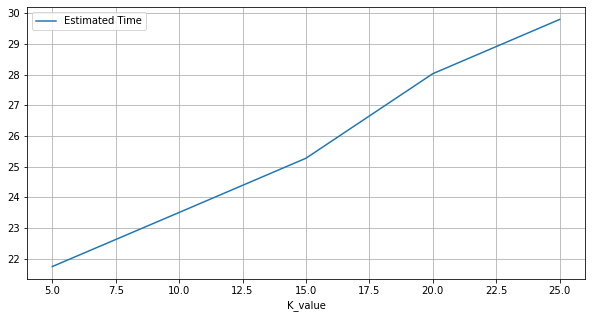

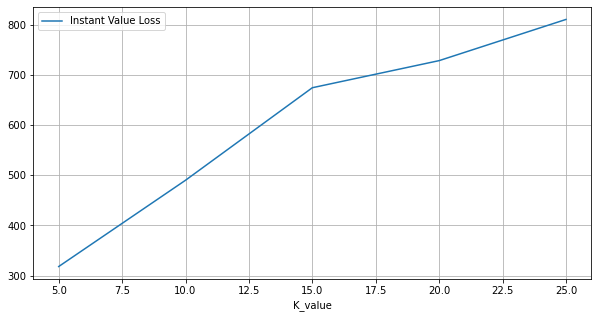

In [11]:
#Computing metics ETA, Instant value loss 
from IPython.display import clear_output

from scipy.spatial.distance import cosine
from saxpy.paa import paa
from saxpy.znorm import znorm 
from saxpy.alphabet import cuts_for_asize
from saxpy.strfunc import idx2letter
from saxpy.sax import ts_to_string, sax_by_chunking

def letter2idx(letter):    
    return ord(letter) - 97

def empirical_median(paa_idx, seed=23, size=1000000):
   
    paa_reco = np.zeros(paa_idx.shape)
    
    level = np.max(paa_idx) + 1

    if level > 1:
        
        # Get corresponding breakpoints
        breakpoints = cuts_for_asize(level)
        
        # Empirical probabilistic median
        np.random.seed(seed)
        pts = np.random.normal(size=size)
        
        
        # Get interval endpoints [beta_lo; beta_up)
        for i in range(len(paa_idx)):
            
            # due to how breakpoints are stored: [beta_0, ... , beta_{l-1}]
            start_idx = paa_idx[i]
            beta_lo = breakpoints[start_idx]
            if start_idx < level-1:
                beta_up = breakpoints[paa_idx[i]+1]
            else:
                beta_up = np.inf
            
            paa_reco[i] = np.median(pts[(pts >= beta_lo) & (pts < beta_up)])
    
    return paa_reco



def pattern_loss(series,pr,paa_size):
    
    znorm_threshold=0.01
    
    series_norm = znorm(series, znorm_threshold)
    feature_vector = paa(series_norm, paa_size)
    
    # Get breakpoint indexes
    paa_index = np.array([letter2idx(x) for x in pr])
    paa_reconstruct = empirical_median(paa_idx)
     
    
    if (np.sum(feature_vector) > 0) & (np.sum(paa_reconstruct) > 0):
        cd = cosine(feature_vector,paa_reconstruct)
    
    # If both vectors are zero vectors the distance is 0 
    elif (np.sum(feature_vector) == 0) & (np.sum(paa_reconstruct) == 0):
        cd = 0.
        
    else:
        cd = 1.
        
    
    return cd, feature_vector, p_star



def measure_metrics(K_value, P_value, paa_value,data):
    
    max_level = 4
    
    # calculate estimated time taken 
    start_time = time.time()    
    anonymize_list_data = KAPRA(K_value, P_value, paa_value,max_level, data)
    clear_output()
    end_time = time.time()
    Estimated_time_taken = round(float(end_time - start_time), 3)
    
    print ('ETA :' + str(Estimated_time_taken))
    
    
    #Calculating Instant value loss
    anonym_Instant_value_loss = 0
    anonymize_df = anonymize_list_data

    anonymize_df = anonymize_df.iloc[: , :-2]
    
    attribute_list = [list(anonymize_df.iloc[i]) for i in range(len(anonymize_df))]  # Quasi-identifier attributes
    first_row = list(anonymize_df.iloc[0])

    r_plus  = [0 for _ in range(len(first_row))]
    r_minus = [0 for _ in range(len(first_row))]
        
    for i in range(len(first_row)):  
        re = first_row[i]
        mn,mx = re[1:-1].split('-')
        r_minus[i] = int(mn)
        r_plus[i] = int(mx)

    anonym_Instant_value_loss += instant_value_loss(attribute_list, r_plus=r_plus, r_minus=r_minus)
    

    '''
    #calculating Pattern loss
    t_series = len(data)
    p_loss = np.zeros((t_series,))
    anonymize_df =anonymize_list_data.iloc[: , :-1]
    
    for idx, k in enumerate(data.keys()):
        
        if k in anonymize_df.keys():
            
            series = data[k]
            pr = anonymize_df[k]
            paa_size = len(pr)
            
            pl,_,_ = pattern_loss(series,pr,paa_size)
            
            pattern_loss[idx] = pl
            
            
    pattern_loss_t = np.sum(p_loss) 
    
    '''

    return Estimated_time_taken,anonym_Instant_value_loss #,pattern_loss_t

    

K_value = {5,10,15,20,25}

paa_value = 5
time_series_data = time_series_dict  

Varying_K =pd.DataFrame(columns=['K_value', 'P_value' ,'Estimated Time', 'Instant Value Loss'])
Varying_P =pd.DataFrame(columns=['K_value', 'P_value', 'Estimated Time', 'Instant Value Loss'])

for i in K_value :
    K_value = i
    P_value = 2
    ETA, IVL= measure_metrics(K_value, P_value, paa_value,time_series_data) 
    df2 = pd.DataFrame([[i,P_value,ETA,IVL]], columns=['K_value', 'P_value', 'Estimated Time', 'Instant Value Loss'])
    Varying_K=Varying_K.append(df2)
        
Varying_K =Varying_K.sort_values(by=['K_value'])
print(Varying_K)

Varying_K.plot(x='K_value', y='Estimated Time' ,figsize=(10,5), grid=True)
Varying_K.plot(x='K_value', y='Instant Value Loss' ,figsize=(10,5), grid=True)



In [12]:
P_value = {2,3,4,5,6}
for j in P_value :
    K_value = 5
    P_value = j
    ETA, IVL= measure_metrics(K_value, P_value, paa_value,time_series_data) 
    df3 = pd.DataFrame([[K_value,j,ETA,IVL]], columns=['K_value', 'P_value', 'Estimated Time', 'Instant Value Loss'])
    Varying_P=Varying_P.append(df3)
        
Varying_P =Varying_P.sort_values(by=['P_value'])
print(Varying_P)

Varying_P.plot(x='P_value', y='Estimated Time' ,figsize=(10,5), grid=True)
Varying_P.plot(x='P_value', y='Instant Value Loss' ,figsize=(10,5), grid=True)

    

ETA :10.232
Create-tree phase: start node splitting


2022-04-23 11:10:46.351 | INFO     | Naive.node:start_splitting:89 - N can be split
2022-04-23 11:10:46.352 | INFO     | Naive.node:start_splitting:90 - Compute tentative good nodes and tentative bad nodes
2022-04-23 11:10:46.354 | INFO     | Naive.node:start_splitting:125 - Merge all bad nodes in a single node, and label it as good-leaf
2022-04-23 11:10:46.355 | INFO     | Naive.node:start_splitting:136 - Split only tg_nodes 25
2022-04-23 11:10:46.386 | INFO     | Naive.node:start_splitting:89 - N can be split
2022-04-23 11:10:46.388 | INFO     | Naive.node:start_splitting:90 - Compute tentative good nodes and tentative bad nodes
2022-04-23 11:10:46.390 | INFO     | Naive.node:start_splitting:152 - Label all tb_node 2 as bad-leaf and split only tg_nodes 1
2022-04-23 11:10:46.412 | INFO     | Naive.node:start_splitting:89 - N can be split
2022-04-23 11:10:46.415 | INFO     | Naive.node:start_splitting:90 - Compute tentative good nodes and tentative bad nodes
2022-04-23 11:10:46.418 | I

2022-04-23 11:10:47.672 | INFO     | Naive.node:start_splitting:90 - Compute tentative good nodes and tentative bad nodes
2022-04-23 11:10:47.673 | INFO     | Naive.node:start_splitting:152 - Label all tb_node 0 as bad-leaf and split only tg_nodes 1
2022-04-23 11:10:47.781 | INFO     | Naive.node:start_splitting:89 - N can be split
2022-04-23 11:10:47.782 | INFO     | Naive.node:start_splitting:90 - Compute tentative good nodes and tentative bad nodes
2022-04-23 11:10:47.783 | INFO     | Naive.node:start_splitting:152 - Label all tb_node 0 as bad-leaf and split only tg_nodes 6
2022-04-23 11:10:47.830 | INFO     | Naive.node:start_splitting:89 - N can be split
2022-04-23 11:10:47.831 | INFO     | Naive.node:start_splitting:90 - Compute tentative good nodes and tentative bad nodes
2022-04-23 11:10:47.833 | INFO     | Naive.node:start_splitting:152 - Label all tb_node 0 as bad-leaf and split only tg_nodes 1
2022-04-23 11:10:47.872 | INFO     | Naive.node:start_splitting:89 - N can be spli

2022-04-23 11:10:48.839 | INFO     | Naive.node:start_splitting:152 - Label all tb_node 0 as bad-leaf and split only tg_nodes 1
2022-04-23 11:10:48.901 | INFO     | Naive.node:start_splitting:89 - N can be split
2022-04-23 11:10:48.903 | INFO     | Naive.node:start_splitting:90 - Compute tentative good nodes and tentative bad nodes
2022-04-23 11:10:48.904 | INFO     | Naive.node:start_splitting:152 - Label all tb_node 0 as bad-leaf and split only tg_nodes 1
2022-04-23 11:10:48.970 | INFO     | Naive.node:start_splitting:89 - N can be split
2022-04-23 11:10:48.971 | INFO     | Naive.node:start_splitting:90 - Compute tentative good nodes and tentative bad nodes
2022-04-23 11:10:48.973 | INFO     | Naive.node:start_splitting:152 - Label all tb_node 0 as bad-leaf and split only tg_nodes 1
2022-04-23 11:10:49.052 | INFO     | Naive.node:start_splitting:89 - N can be split
2022-04-23 11:10:49.053 | INFO     | Naive.node:start_splitting:90 - Compute tentative good nodes and tentative bad node

Good leaf nodes :54 Bad leaf nodes :15

 recyling bad leaves phases starts
[<Naive.node.Node object at 0x000001E573A14940>, <Naive.node.Node object at 0x000001E573A14BE0>, <Naive.node.Node object at 0x000001E573A14E20>, <Naive.node.Node object at 0x000001E573D4DBB0>, <Naive.node.Node object at 0x000001E573D4DFA0>, <Naive.node.Node object at 0x000001E573D4DA90>, <Naive.node.Node object at 0x000001E573D6D1C0>, <Naive.node.Node object at 0x000001E573D6D490>, <Naive.node.Node object at 0x000001E573D6D370>, <Naive.node.Node object at 0x000001E573D6D880>, <Naive.node.Node object at 0x000001E573D6D940>, <Naive.node.Node object at 0x000001E573D6D250>, <Naive.node.Node object at 0x000001E573D6D9A0>, <Naive.node.Node object at 0x000001E573D6D520>, <Naive.node.Node object at 0x000001E573D6DEE0>]
Start group formation phase


IndexError: list index out of range